In [1]:
import json
import joblib
from pprint import pprint
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

import lightgbm as lgb
from lightgbm.callback import log_evaluation, early_stopping

from isic_helper import DotDict
from isic_helper import get_folds
from isic_helper import compute_auc, compute_pauc

pd.options.display.max_columns = 1000

In [2]:
cfg = DotDict()
cfg.seed = 2022

cfg.models_output_dir = "models"
cfg.model_name = "lgb_v3"

In [3]:
id_column = "isic_id"
target_column = "target"
group_column = "patient_id"

In [4]:
def count_features(df, col):
    tmp = df[[id_column, group_column, col]].pivot_table(
        values=id_column, 
        index=group_column, 
        columns=col, 
        aggfunc="count", 
        fill_value=0)
    feature_cols = tmp.columns.tolist()
    tmp.reset_index(inplace=True)
    tmp.index.name = None
    df = df.merge(tmp, on=group_column, how="left")
    return df, feature_cols

def mean_features(df, col, val):
    tmp = df[[id_column, group_column, col, val]].pivot_table(
        values=val, 
        index=group_column, 
        columns=col, 
        aggfunc="mean", 
        fill_value=0)
    tmp.columns = [f"{c}_{val}_mean" for c in tmp.columns.tolist()]
    feature_cols = tmp.columns.tolist()
    tmp.reset_index(inplace=True)
    tmp.index.name = None
    df = df.merge(tmp, on=group_column, how="left")
    return df, feature_cols


def stat_features(df, group_cols, value_col, stats):
    tmp = df.groupby(group_cols)[value_col].agg(stats)
    tmp.columns = [f"{value_col}_{stat}" for stat in stats]
    tmp.reset_index(inplace=True)
    df = df.merge(tmp, on=group_cols, how="left")
    df[f"{value_col}_mean_diff"] = df[value_col] - df[f"{value_col}_mean"]
    return df


def feature_engineering(df):
    new_num_cols = []
    
    df["lesion_size_ratio"] = df["tbp_lv_minorAxisMM"] / df["clin_size_long_diam_mm"]
    new_num_cols += ["lesion_size_ratio"]
    
    df["lesion_distance"] = np.sqrt(df["tbp_lv_x"]**2 + df["tbp_lv_y"]**2 + df["tbp_lv_z"]**2)
    new_num_cols += ["lesion_distance"]
    
    df["hue_contrast"] = df["tbp_lv_H"] - df["tbp_lv_Hext"]
    df, feature_cols = mean_features(df, "anatom_site_general", "hue_contrast")
    new_num_cols += feature_cols
    
    df, feature_cols = count_features(df, "anatom_site_general")
    new_num_cols += feature_cols
    
    df["tbp_lv_A_diff"] =  df["tbp_lv_Aext"] - df["tbp_lv_A"]
    df = stat_features(df, ["patient_id", "tbp_lv_location"], "tbp_lv_A_diff", ["mean"])
    new_num_cols += ["tbp_lv_A_diff_mean_diff"]
    
    df["tbp_lv_B_diff"] =  df["tbp_lv_Bext"] - df["tbp_lv_B"]
    df = stat_features(df, ["patient_id", "tbp_lv_location"], "tbp_lv_B_diff", ["mean"])
    new_num_cols += ["tbp_lv_B_diff_mean_diff"]
    
    df["tbp_lv_L_diff"] =  df["tbp_lv_Lext"] - df["tbp_lv_L"]
    df = stat_features(df, ["patient_id", "tbp_lv_location"], "tbp_lv_L_diff", ["mean"])
    new_num_cols += ["tbp_lv_L_diff_mean_diff"]
    
    df["tbp_lv_L_std_diff"] =  df["tbp_lv_stdLExt"] - df["tbp_lv_stdL"]
    df = stat_features(df, ["patient_id", "tbp_lv_location"], "tbp_lv_L_std_diff", ["mean"])
    new_num_cols += ["tbp_lv_L_std_diff_mean_diff"]
    
    df["color_uniformity"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_radial_color_std_max"]
    df, feature_cols = mean_features(df, "anatom_site_general", "color_uniformity")
    new_num_cols += feature_cols
    
    df["radius"] = np.cos(df["tbp_lv_symm_2axis_angle"]) * np.sqrt(df["tbp_lv_x"]**2 + df["tbp_lv_y"]**2 + df["tbp_lv_z"]**2)
    new_num_cols += ["radius"]
    
    return df, new_num_cols

In [5]:
INPUT_PATH = Path("../input/isic-2024-challenge/")
MODELS_OUTPUT_PATH = Path(f"{cfg.models_output_dir}")
MODELS_OUTPUT_PATH.mkdir(exist_ok=True)

train_metadata = pd.read_csv(INPUT_PATH / "train-metadata.csv", low_memory=False)
test_metadata = pd.read_csv(INPUT_PATH / "test-metadata.csv")

folds_df = get_folds()
train_metadata = train_metadata.merge(folds_df, on=["isic_id", "patient_id"], how="inner")
print(f"Train data size: {train_metadata.shape}")
print(f"Test data size: {test_metadata.shape}")

train_metadata, new_num_cols = feature_engineering(train_metadata.copy())
test_metadata, _ = feature_engineering(test_metadata.copy())

Train data size: (401059, 57)
Test data size: (3, 44)


In [6]:
train_metadata.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,multiclass_target,fold,lesion_size_ratio,lesion_distance,hue_contrast,anterior torso_hue_contrast_mean,head/neck_hue_contrast_mean,lower extremity_hue_contrast_mean,posterior torso_hue_contrast_mean,upper extremity_hue_contrast_mean,anterior torso,head/neck,lower extremity,posterior torso,upper extremity,tbp_lv_A_diff,tbp_lv_A_diff_mean,tbp_lv_A_diff_mean_diff,tbp_lv_B_diff,tbp_lv_B_diff_mean,tbp_lv_B_diff_mean_diff,tbp_lv_L_diff,tbp_lv_L_diff_mean,tbp_lv_L_diff_mean_diff,tbp_lv_L_std_diff,tbp_lv_L_std_diff_mean,tbp_lv_L_std_diff_mean_diff,color_uniformity,anterior torso_color_uniformity_mean,head/neck_color_uniformity_mean,lower extremity_color_uniformity_mean,posterior torso_color_uniformity_mean,upper extremity_color_uniformity_mean,radius
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,55.828924,54.367448,62.025701,3.152561,27.476170,0.00000,3.982447,2.967674,-7.658253,8.360566,5.784302,0.901302,Right Leg - Upper,Right Leg,1.543016,2.628592e-03,7.091360,0.000000,9.307003,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,0_Benign:Weak,4,0.507571,641.525666,-2.770379,-4.689356,-1.110874,-4.336041,-4.336349,-4.783558,191.0,8.0,118.0,121.0,72.0,-3.982447,-3.685802,-0.296645,-2.967674,-1.073571,-1.894103,7.658253,9.775050,-2.116797,0.601585,-0.521064,1.122649,NaN,inf,1.154445,1.015490,inf,inf,-631.502882
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,44.064040,48.861520,55.362360,0.919497,12.235290,0.00000,6.347830,1.781713,-6.500838,6.839008,4.987244,0.639885,Head & Neck,Head & Neck,0.821918,1.334303e-07,2.116402,0.000000,3.354148,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,Memorial Sloan Kettering Cancer Center,CC-BY,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,0_Benign:Strong,1,0.747198,1576.723962,-4.361130,-4.421667,-3.534137,-6.157595,-3.668893,-4.114276,27.0,8.0,37.0,16.0,25.0,-6.347830,-3.938782,-2.409048,-1.781710,-1.165544,-0.616166,6.500840,7.545856,-1.045016,3.059617,1.603739,1.455878,NaN,1.069864,1.001586,inf,inf,inf,34.887787
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,17.128170,37.970460,33.485410,44.174920,37.611800,59.265850,62.909730,53.961180,61.670520,3.265153,24.184620,0.00000,5.447655,4.485044,-7.709336,9.092376,6.290359,0.932147,Torso Back Top Third,Torso Back,1.194905,2.959177e-04,4.798335,0.000000,8.886309,0.00000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,0_Benign:Weak,5,0.351443,1495.442825,-3.643880,-4.190243,-0.958026,-5.811371,-3.632645,-3.084955,527.0,34.0,536.0,466.0,296.0,-5.447660,-4.309035,-1.138625,-4.485050,-3.577588,-0.907462,7.709340,6.455907,1.253433,0.207126,0.544733,-0.337607,NaN,inf,inf,inf,inf,inf,-360.340481
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: 

In [7]:
ord_categorical_features = [
#     "sex", 
#     "anatom_site_general", 
    "tbp_tile_type", 
    "tbp_lv_location", 
#     "tbp_lv_location_simple",
    "attribution", "copyright_license"
]
ohe_categorical_features = []
numerical_features = [
    "age_approx", 
    "clin_size_long_diam_mm",
    "tbp_lv_A", "tbp_lv_Aext",
    "tbp_lv_B", "tbp_lv_Bext",
    "tbp_lv_C", "tbp_lv_Cext",
    "tbp_lv_H", "tbp_lv_Hext",
    "tbp_lv_L", "tbp_lv_Lext",
    "tbp_lv_areaMM2",
    "tbp_lv_area_perim_ratio",
    "tbp_lv_color_std_mean",
    "tbp_lv_deltaA", "tbp_lv_deltaB", "tbp_lv_deltaL", "tbp_lv_deltaLB", "tbp_lv_deltaLBnorm",
    "tbp_lv_eccentricity",
    "tbp_lv_minorAxisMM",
    "tbp_lv_nevi_confidence",
    "tbp_lv_norm_border", "tbp_lv_norm_color",
    "tbp_lv_perimeterMM",
    "tbp_lv_radial_color_std_max",
    "tbp_lv_stdL", "tbp_lv_stdLExt",
    "tbp_lv_symm_2axis", "tbp_lv_symm_2axis_angle",
    "tbp_lv_x", "tbp_lv_y", "tbp_lv_z"
]
numerical_features += new_num_cols

mixed_encoded_preprocessor = ColumnTransformer(
    [
        ("numerical", "passthrough", numerical_features),
        (
            "ord_categorical",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-2, encoded_missing_value=-1, dtype=int),
            ord_categorical_features,
        ),
        (
            "ohe_categorical",
            OneHotEncoder(sparse_output=False),
            ohe_categorical_features
        )
    ],
    verbose_feature_names_out=False,

)
mixed_encoded_preprocessor.set_output(transform="pandas")

with open(f"{cfg.model_name}_encoder.joblib", "wb") as f:
    joblib.dump(mixed_encoded_preprocessor, f)

In [8]:
train_ids = train_metadata[id_column]
groups = train_metadata[group_column]
folds = train_metadata["fold"]

enc = mixed_encoded_preprocessor.fit(train_metadata)
X_train = enc.transform(train_metadata)
y_train = train_metadata[target_column]

categorical_features = ord_categorical_features[:]
for ohe_col in ohe_categorical_features:
    categorical_features += [col for col in X_train.columns if col.startswith(ohe_col)]

print(f"Total number of columns: {len(X_train.columns)}")

Total number of columns: 60


In [9]:
def pauc_80(preds, data):
    score_value = compute_pauc(data.get_label(), preds, min_tpr=0.8)   
    return 'pauc_80', score_value, True


params = {
    "objective": "binary",
    "metric": "custom",
    "metric_freq": 10,
    "num_leaves": 63,
    "learning_rate": 0.01,
    "bagging_freq": 6,
    "bagging_fraction": 0.6,
    "bagging_seed": cfg.seed,
    "feature_fraction": 0.3,
    "feature_fraction_seed": cfg.seed,
    "lambda_l1": 0.95,
    "lambda_l2": 0.95,
    "verbosity": -1
}
num_rounds = 3000
es_rounds = 250
log_rounds = 50

In [10]:
best_num_rounds = {}
val_auc_scores = {}
val_pauc_scores = {}
all_folds = np.sort(folds.unique())
oof_predictions = np.zeros(X_train.shape[0])
for fold in all_folds:
#     if fold != 3:
#         continue
    print(f"Running fold: {fold}")
    dev_index = folds[folds != fold].index
    val_index = folds[folds == fold].index
    
    X_dev = X_train.loc[dev_index, :]
    y_dev = y_train[dev_index]
    
    X_val = X_train.loc[val_index, :]
    y_val = y_train[val_index]
    
    lgb_dataset_dev = lgb.Dataset(X_dev, label=y_dev, categorical_feature=categorical_features, free_raw_data=False)
    lgb_dataset_val = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(
        params,
        lgb_dataset_dev,
        num_boost_round=num_rounds,
        valid_sets=[lgb_dataset_val],
        feval=pauc_80,
        callbacks=[early_stopping(stopping_rounds=es_rounds), log_evaluation(log_rounds)],
    )
    
    model.save_model(MODELS_OUTPUT_PATH / f"{cfg.model_name}_fold_{fold}.txt")
    best_num_rounds[f"fold_{fold}"] = model.best_iteration
    val_scores = dict(model.best_score["valid_0"])
    
    val_preds = model.predict(X_val, num_iteration=model.best_iteration)
    oof_predictions[val_index] = val_preds
    
    val_auc_scores[f"fold_{fold}"] = compute_auc(y_val, val_preds)
    val_pauc_scores[f"fold_{fold}"] = val_scores["pauc_80"]
    print("\n")

print("Val AUC scores:")
pprint(val_auc_scores)
print("Val PAUC scores:")
pprint(val_pauc_scores)

oof_preds_df = pd.DataFrame({
    id_column: train_ids,
    group_column: groups,
    "fold": folds,
    target_column: y_train,
    f"oof_{cfg.model_name}": oof_predictions
})
oof_preds_df.to_csv(f"oof_preds_{cfg.model_name}.csv", index=False)

cv_auc_oof = compute_auc(oof_preds_df[target_column], oof_preds_df[f"oof_{cfg.model_name}"])
cv_pauc_oof = compute_pauc(oof_preds_df[target_column], oof_preds_df[f"oof_{cfg.model_name}"], min_tpr=0.8)

cv_auc_avg = np.mean(list(val_auc_scores.values()))
cv_pauc_avg = np.mean(list(val_pauc_scores.values()))

cv_auc_std = np.std(list(val_auc_scores.values()))
cv_pauc_std = np.std(list(val_pauc_scores.values()))

print(f"CV AUC OOF: {cv_auc_oof}")
print(f"CV PAUC OOF: {cv_pauc_oof}")
print(f"CV AUC AVG: {cv_auc_avg}")
print(f"CV PAUC AVG: {cv_pauc_avg}")
print(f"CV AUC STD: {cv_auc_std}")
print(f"CV PAUC STD: {cv_pauc_std}")
print(X_train.columns)

Running fold: 1
Training until validation scores don't improve for 250 rounds
[50]	valid_0's pauc_80: 0.154282
[100]	valid_0's pauc_80: 0.155205
[150]	valid_0's pauc_80: 0.155538
[200]	valid_0's pauc_80: 0.157661
[250]	valid_0's pauc_80: 0.159316
[300]	valid_0's pauc_80: 0.160629
[350]	valid_0's pauc_80: 0.16189
[400]	valid_0's pauc_80: 0.164048
[450]	valid_0's pauc_80: 0.164785
[500]	valid_0's pauc_80: 0.165419
[550]	valid_0's pauc_80: 0.165747
[600]	valid_0's pauc_80: 0.166175
[650]	valid_0's pauc_80: 0.166281
[700]	valid_0's pauc_80: 0.167011
[750]	valid_0's pauc_80: 0.167977
[800]	valid_0's pauc_80: 0.168639
[850]	valid_0's pauc_80: 0.168821
[900]	valid_0's pauc_80: 0.168548
[950]	valid_0's pauc_80: 0.168217
[1000]	valid_0's pauc_80: 0.168452
[1050]	valid_0's pauc_80: 0.168401
[1100]	valid_0's pauc_80: 0.168261
Early stopping, best iteration is:
[850]	valid_0's pauc_80: 0.168821


Running fold: 2
Training until validation scores don't improve for 250 rounds
[50]	valid_0's pauc_80: 

<Axes: >

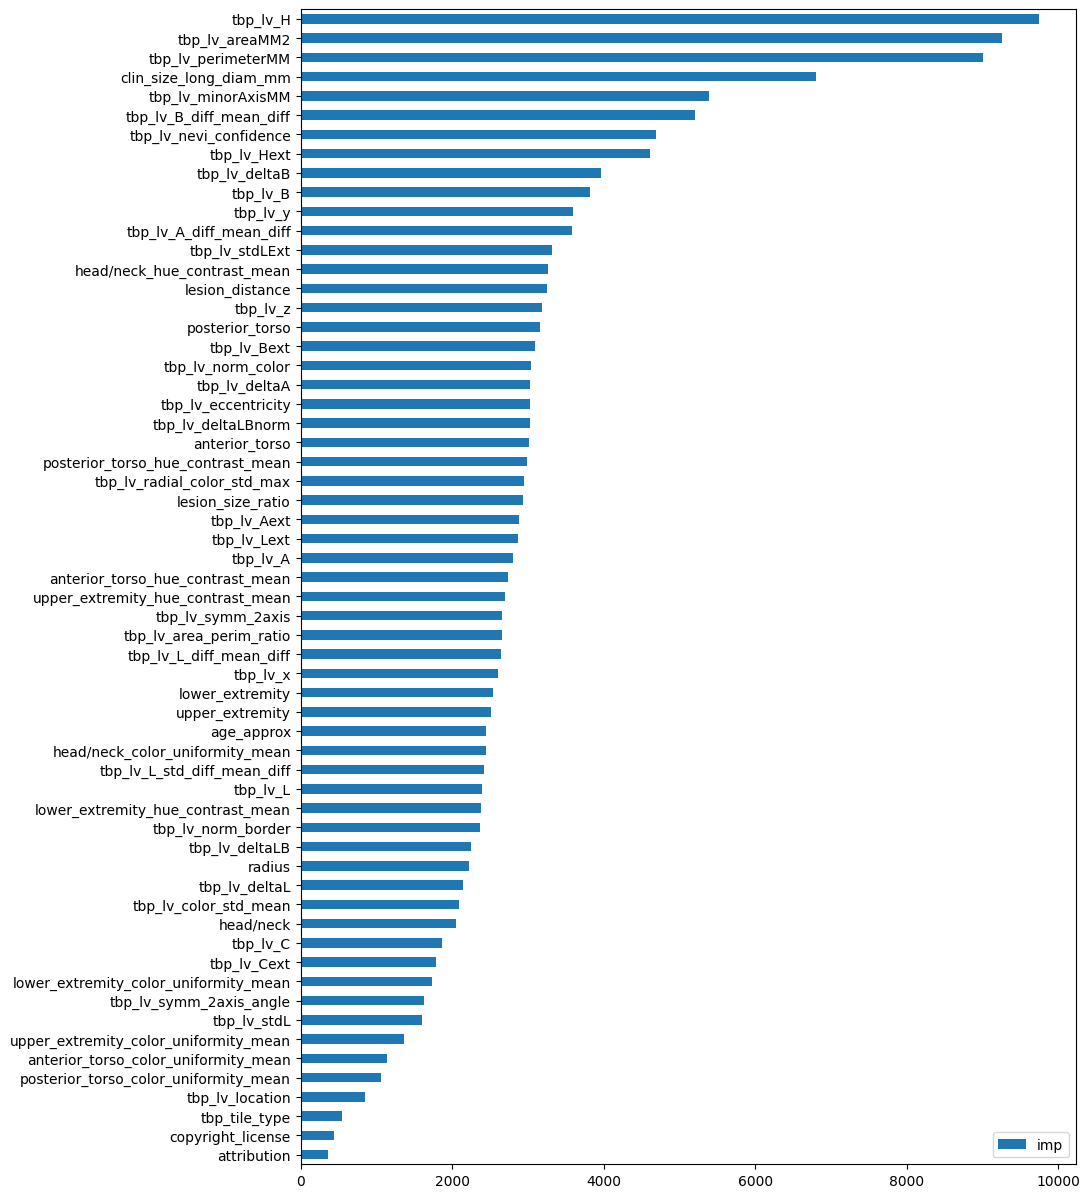

In [11]:
feature_importances = 0
for fold in all_folds:
    model = lgb.Booster(model_file=MODELS_OUTPUT_PATH / f"{cfg.model_name}_fold_{fold}.txt")
    if fold == 1:
        feature_names = model.feature_name()
    feature_importances += model.feature_importance(importance_type="gain")
feature_importances /= len(all_folds)

imp = pd.DataFrame.from_dict(dict(zip(feature_names, feature_importances)), 
                             orient="index", columns=["imp"]).sort_values("imp", ascending=True)
imp.plot(kind="barh", figsize=(10, 15))

In [12]:
metadata = {
    "params": params,
    "num_rounds": num_rounds,
    "es_rounds": es_rounds,
    "best_num_rounds": best_num_rounds,
    "val_auc_scores": val_auc_scores,
    "val_pauc_scores": val_pauc_scores,
    "cv_auc_oof": cv_auc_oof,
    "cv_pauc_oof": cv_pauc_oof,
    "cv_auc_avg": cv_auc_avg,
    "cv_pauc_avg": cv_pauc_avg
}

with open(f"{cfg.model_name}_run_metadata.json", "w") as f:
    json.dump(metadata, f)